## Identify TACO (Transfusion-associated circulatory overload) by ICD codes

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [6]:
# ICD codes
with open(f"{query_path}/taco_icd_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  ROW_ID_1 ICD9_CODE_1  \
0     430095       51200   102649       22      7851     12415        7851   
1     546228       76562   109750        4      7852     12986        7852   
2     609382       90911   175746       16      7852     12986        7852   
3     464155       58433   143337       12     78605     13000       78605   
4      18199        1616   177269        8     78605     13000       78605   
...      ...         ...      ...      ...       ...       ...         ...   
5636  404685       45803   127911       14     78609     13003       78609   
5637  617359       92652   127180       13     78609     13003       78609   
5638  533037       73713   107252        9     78609     13003       78609   
5639  414105       47862   199399       20     78609     13003       78609   
5640  417781       48637   148117        9     78609     13003       78609   

                 SHORT_TITLE                       LONG_TITLE  

In [47]:
icd_counts = results[['ICD9_CODE', 'LONG_TITLE']].drop_duplicates().reset_index()
icd_counts['Pt_Count'] = results.drop_duplicates(['SUBJECT_ID', 'ICD9_CODE']).groupby('ICD9_CODE').count().iloc[:,0].values
icd_counts

,index,ICD9_CODE,LONG_TITLE,Pt_Count
0,0,7851,Palpitations,215
1,1,7852,Undiagnosed cardiac murmurs,1926
2,3,78605,Shortness of breath,131
3,13,4280,"Congestive heart failure, unspecified",1586
4,3091,5184,"Acute edema of lung, unspecified",111
5,3223,7823,Edema,169
6,3336,7850,"Tachycardia, unspecified",4
7,3515,27669,Other fluid overload,4
8,3739,51881,Acute respiratory failure,5
9,5597,78609,Other respiratory abnormalities,43


In [48]:
icd_counts['Pt_Count'].sum()

np.int64(4194)

We're lacking temporal data still

## Identify TACO (Transfusion-associated circulatory overload) by lab values
lab values have time recorded 

In [3]:
# Lab values 
with open(f"{query_path}/taco_lab_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ch123ck/transfusion-reactions/queries/taco_lab_1d.sql'

In [15]:
lab_vars = results['LABEL'].values

HR_var = [item for item in lab_vars if re.findall("heart rate", item, re.IGNORECASE)]
HR_var

['Heart rate Alarm - High',
 'Heart Rate',
 'Heart Rate',
 'Heart Rate Alarm - Low']

In [12]:
RR_var = [item for item in lab_vars if re.findall("Resp rate", item, re.IGNORECASE)]
RR_var

['Resp Rate (Spont)', 'Resp Rate (Total)']

In [13]:
SpO2_var = [item for item in lab_vars if re.findall("spo2", item, re.IGNORECASE)]
SpO2_var

['SpO2 Desat Limit', 'SpO2 Alarm [Low]', 'SpO2', 'SpO2 Alarm [High]', 'SpO2-L']

In [14]:
BP_var = [item for item in lab_vars if re.findall("blood pressure", item, re.IGNORECASE)]
BP_var

['Manual Blood Pressure Diastolic Left',
 'Arterial Blood Pressure mean',
 'ART Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm Source',
 'Non Invasive Blood Pressure diastolic',
 'Manual Blood Pressure Systolic Left',
 'Non-Invasive Blood Pressure Alarm - Low',
 'Non Invasive Blood Pressure mean',
 'Arterial Blood Pressure systolic',
 'Non-Invasive Blood Pressure Alarm - High',
 'Manual Blood Pressure Systolic Right',
 'Non Invasive Blood Pressure systolic',
 'Arterial Blood Pressure diastolic',
 'Manual Blood Pressure Diastolic Right']

Vital Variables: 

'Heart Rate' 

'Resp Rate (Spont)', 'Resp Rate (Total)'

'SpO2'

'Manual Blood Pressure Diastolic Left', 'Non Invasive Blood Pressure diastolic', 'Manual Blood Pressure Systolic Left', 'Manual Blood Pressure Systolic Right', 'Non Invasive Blood Pressure systolic', 'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic', 'Manual Blood Pressure Diastolic Right'

In [4]:
# results.to_csv('/home/ch123ck/transfusion-reactions/exploratory_data_analysis/chart_labels_2.csv')

### Clean vitals data before transfusion reaction

In [25]:
## Use sql to query vitals and time
## Get vitals before transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_before_mergedtr.sql", 'r') as file:
    query_icd = file.read()

before_results = client.query(query_icd).to_dataframe()
print(before_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME           starttime  ITEMID  \
0             30659 2146-03-08 15:07:00 2146-03-08 22:52:00  220179   
1             59970 2198-05-26 15:55:00 2198-05-26 20:08:00  220179   
2             30659 2146-03-08 15:07:00 2146-03-08 16:16:00  220179   
3             30659 2146-03-08 15:07:00 2146-03-08 16:36:00  220179   
4             70723 2163-11-18 10:40:00 2163-11-18 21:22:00  220179   
...             ...                 ...                 ...     ...   
2506963       57333 2178-10-13 10:00:00 2178-10-13 21:20:00  224689   
2506964         222 2142-06-26 03:00:00 2142-06-26 14:00:00     211   
2506965       29753 2188-08-27 23:00:00 2188-08-28 01:00:00     211   
2506966         222 2142-06-26 09:00:00 2142-06-26 14:00:00     211   
2506967       30460 2163-02-22 06:00:00 2163-02-22 13:03:00     211   

                                        LABEL VALUE  VALUENUM  VALUEUOM  
0        Non Invasive Blood Pressure systolic    31      31.0      mmHg  

In [26]:
# Look at the counts of each vital
before_results['LABEL'].value_counts()

LABEL
Heart Rate                               502255
Respiratory Rate                         495502
O2 saturation pulseoxymetry              478448
Arterial Blood Pressure systolic         271607
Arterial Blood Pressure diastolic        271559
Non Invasive Blood Pressure systolic     198511
Non Invasive Blood Pressure diastolic    198365
Respiratory Rate (spontaneous)            90145
Manual Blood Pressure Systolic Left         139
Manual Blood Pressure Diastolic Left        135
SpO2                                        106
Manual Blood Pressure Systolic Right         93
Manual Blood Pressure Diastolic Right        82
Resp Rate (Total)                            12
Respiratory Rate Set                          5
Resp Rate (Spont)                             4
Name: count, dtype: int64

In [27]:
## Unique patient counts 
len(before_results['SUBJECT_ID'].unique())

5823

In [28]:
# Look at a patient's heart rate data 
sub_hr = before_results[before_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_hr[sub_hr['SUBJECT_ID'] == 34]

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
2476256,34,2191-02-23 05:25:00,2191-02-23 16:19:00,220045,Heart Rate,72,72.0,bpm
1543329,34,2191-02-23 07:34:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
1329009,34,2191-02-23 08:00:00,2191-02-23 16:19:00,220045,Heart Rate,43,43.0,bpm
612411,34,2191-02-23 08:10:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
1329011,34,2191-02-23 08:20:00,2191-02-23 16:19:00,220045,Heart Rate,44,44.0,bpm
2330554,34,2191-02-23 09:00:00,2191-02-23 16:19:00,220045,Heart Rate,47,47.0,bpm
612625,34,2191-02-23 10:00:00,2191-02-23 16:19:00,220045,Heart Rate,56,56.0,bpm
971278,34,2191-02-23 11:00:00,2191-02-23 16:19:00,220045,Heart Rate,51,51.0,bpm
827550,34,2191-02-23 12:00:00,2191-02-23 16:19:00,220045,Heart Rate,52,52.0,bpm
111073,34,2191-02-23 13:00:00,2191-02-23 16:19:00,220045,Heart Rate,53,53.0,bpm


In [29]:
## Add category to the label 
# Define the conditions and categories
conditions = [
    (before_results['LABEL'] == 'Heart Rate'),
    (before_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (before_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (before_results['LABEL'].isin(['SpO2', 'O2 saturation pulseoxymetry'])),
    (before_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)', 'Respiratory Rate', 'Respiratory Rate Set', 'Respiratory Rate (spontaneous)']))
]

categories = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
before_results['Category'] = np.select(conditions, categories, default='Unknown')
before_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,30659,2146-03-08 15:07:00,2146-03-08 22:52:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
1,59970,2198-05-26 15:55:00,2198-05-26 20:08:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
2,30659,2146-03-08 15:07:00,2146-03-08 16:16:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
3,30659,2146-03-08 15:07:00,2146-03-08 16:36:00,220179,Non Invasive Blood Pressure systolic,31,31.0,mmHg,BP_SYS
4,70723,2163-11-18 10:40:00,2163-11-18 21:22:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...
2506963,57333,2178-10-13 10:00:00,2178-10-13 21:20:00,224689,Respiratory Rate (spontaneous),650,650.0,insp/min,RR
2506964,222,2142-06-26 03:00:00,2142-06-26 14:00:00,211,Heart Rate,63,63.0,BPM,HR
2506965,29753,2188-08-27 23:00:00,2188-08-28 01:00:00,211,Heart Rate,80,80.0,BPM,HR
2506966,222,2142-06-26 09:00:00,2142-06-26 14:00:00,211,Heart Rate,84,84.0,BPM,HR


In [30]:
# Get only the closest record per vital sign to the start date
# Ensure STARTTIME is in datetime format
before_results['starttime'] = pd.to_datetime(before_results['starttime'])

# Sort by SUBJECT_ID, Category, and STARTTIME (latest first)
before_results_sorted = before_results.sort_values(by=['SUBJECT_ID', 'Category', 'starttime'], ascending=[True, True, False])

# Drop duplicates to keep only the latest STARTTIME for each SUBJECT_ID and Category
before_unique = before_results_sorted.drop_duplicates(subset=['SUBJECT_ID', 'Category'], keep='first')

# Reset index for a clean DataFrame
before_unique = before_unique.reset_index(drop=True)

# Display the result
before_unique

,SUBJECT_ID,CHARTTIME,starttime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,34,2191-02-23 08:00:00,2191-02-23 16:19:00,220180,Non Invasive Blood Pressure diastolic,57,57.0,mmHg,BP_DIA
1,34,2191-02-23 13:00:00,2191-02-23 16:19:00,220179,Non Invasive Blood Pressure systolic,117,117.0,mmHg,BP_SYS
2,34,2191-02-23 13:00:00,2191-02-23 16:19:00,220045,Heart Rate,53,53.0,bpm,HR
3,34,2191-02-23 10:00:00,2191-02-23 16:19:00,220210,Respiratory Rate,17,17.0,insp/min,RR
4,34,2191-02-23 07:44:00,2191-02-23 16:19:00,220277,O2 saturation pulseoxymetry,100,100.0,%,SPO2
...,...,...,...,...,...,...,...,...,...
29014,99995,2147-02-08 17:30:00,2147-02-09 00:00:00,220051,Arterial Blood Pressure diastolic,51,51.0,mmHg,BP_DIA
29015,99995,2147-02-08 17:15:00,2147-02-09 00:00:00,220050,Arterial Blood Pressure systolic,153,153.0,mmHg,BP_SYS
29016,99995,2147-02-08 21:15:00,2147-02-09 00:00:00,220045,Heart Rate,74,74.0,bpm,HR
29017,99995,2147-02-08 15:34:00,2147-02-09 00:00:00,224689,Respiratory Rate (spontaneous),0,0.0,insp/min,RR


In [31]:
# Count the number of vital signs and patients
print(before_unique['Category'].value_counts())
print(f"total patient counts: {len(before_unique['SUBJECT_ID'].unique())}")

Category
HR        5820
RR        5818
SPO2      5809
BP_DIA    5786
BP_SYS    5786
Name: count, dtype: int64
total patient counts: 5823


### Clean vitals data after transfusion reaction

In [33]:
## Get vitals after transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_after_mergedtr.sql", 'r') as file:
    query_icd = file.read()

after_results = client.query(query_icd).to_dataframe()
print(after_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME             endtime  ITEMID  \
0             69843 2155-06-27 15:00:00 2155-06-27 13:05:00  220179   
1             72116 2129-01-30 12:00:00 2129-01-30 04:41:00  220179   
2             69843 2155-06-27 15:00:00 2155-06-27 12:22:00  220179   
3             72116 2129-01-30 12:00:00 2129-01-30 11:10:00  220179   
4             59726 2142-11-10 09:10:00 2142-11-10 03:42:00  220179   
...             ...                 ...                 ...     ...   
2741216       28162 2189-03-13 16:00:00 2189-03-13 12:59:00     211   
2741217       32725 2193-09-16 15:00:00 2193-09-16 10:05:00     211   
2741218        8498 2144-08-27 06:00:00 2144-08-27 03:58:00     211   
2741219        8498 2144-08-27 08:45:00 2144-08-27 02:06:00     211   
2741220       28162 2189-03-13 17:00:00 2189-03-13 12:59:00     211   

                                        LABEL VALUE  VALUENUM VALUEUOM  
0        Non Invasive Blood Pressure systolic     0       0.0     mmHg  
1

In [34]:
# Look at the counts of each vital
print(f"Vitals counts : {after_results['LABEL'].value_counts()}")

## Unique patient counts 
print(f"Total patient counts: {len(after_results['SUBJECT_ID'].unique())}")

# Look at a patient's heart rate data 
sub_af_hr = after_results[after_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_af_hr[after_results['SUBJECT_ID'] == 34]

Vitals counts : LABEL
Heart Rate                               546342
Respiratory Rate                         540290
O2 saturation pulseoxymetry              527867
Arterial Blood Pressure systolic         308313
Arterial Blood Pressure diastolic        308263
Non Invasive Blood Pressure systolic     204423
Non Invasive Blood Pressure diastolic    204346
Respiratory Rate (spontaneous)           100891
SpO2                                        134
Manual Blood Pressure Systolic Left         110
Manual Blood Pressure Diastolic Left        104
Manual Blood Pressure Systolic Right         53
Manual Blood Pressure Diastolic Right        43
Resp Rate (Total)                            18
Respiratory Rate Set                         14
Resp Rate (Spont)                            10
Name: count, dtype: int64


Total patient counts: 5827


/tmp/ipykernel_1445/3828629166.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_af_hr[after_results['SUBJECT_ID'] == 34]


,SUBJECT_ID,CHARTTIME,endtime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
2085765,34,2191-02-23 18:00:00,2191-02-23 17:19:00,220045,Heart Rate,55,55.0,bpm
1304048,34,2191-02-23 19:00:00,2191-02-23 17:19:00,220045,Heart Rate,59,59.0,bpm
512617,34,2191-02-23 20:00:00,2191-02-23 17:19:00,220045,Heart Rate,62,62.0,bpm
442538,34,2191-02-23 21:00:00,2191-02-23 17:19:00,220045,Heart Rate,66,66.0,bpm
1374775,34,2191-02-23 22:00:00,2191-02-23 17:19:00,220045,Heart Rate,61,61.0,bpm
2705307,34,2191-02-23 23:00:00,2191-02-23 17:19:00,220045,Heart Rate,54,54.0,bpm
2548048,34,2191-02-24 00:00:00,2191-02-23 17:19:00,220045,Heart Rate,56,56.0,bpm
1374402,34,2191-02-24 01:00:00,2191-02-23 17:19:00,220045,Heart Rate,57,57.0,bpm
2007878,34,2191-02-24 02:00:00,2191-02-23 17:19:00,220045,Heart Rate,55,55.0,bpm
277539,34,2191-02-24 03:00:00,2191-02-23 17:19:00,220045,Heart Rate,56,56.0,bpm


In [37]:
## Add category to the label 
# Define the conditions and categories
conditions = [
    (after_results['LABEL'] == 'Heart Rate'),
    (after_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (after_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (after_results['LABEL'].isin(['SpO2', 'O2 saturation pulseoxymetry'])),
    (after_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)', 'Respiratory Rate', 'Respiratory Rate Set', 'Respiratory Rate (spontaneous)']))
]

categories = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
after_results['Category'] = np.select(conditions, categories, default='Unknown')
after_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,endtime,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,69843,2155-06-27 15:00:00,2155-06-27 13:05:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS
1,72116,2129-01-30 12:00:00,2129-01-30 04:41:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS
2,69843,2155-06-27 15:00:00,2155-06-27 12:22:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS
3,72116,2129-01-30 12:00:00,2129-01-30 11:10:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS
4,59726,2142-11-10 09:10:00,2142-11-10 03:42:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...
2741216,28162,2189-03-13 16:00:00,2189-03-13 12:59:00,211,Heart Rate,77,77.0,BPM,HR
2741217,32725,2193-09-16 15:00:00,2193-09-16 10:05:00,211,Heart Rate,93,93.0,BPM,HR
2741218,8498,2144-08-27 06:00:00,2144-08-27 03:58:00,211,Heart Rate,97,97.0,BPM,HR
2741219,8498,2144-08-27 08:45:00,2144-08-27 02:06:00,211,Heart Rate,97,97.0,BPM,HR


### Examine before vs after transfusion vital signs 

In [38]:
# Perform a left join on SUBJECT_ID and Category
merged_results = after_results.merge(
    before_unique, 
    on=['SUBJECT_ID', 'Category'], 
    how='left', 
    suffixes=('_after', '_before')  # Add suffixes to distinguish overlapping columns
)

# Display the merged DataFrame
merged_results

,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before
0,69843,2155-06-27 15:00:00,2155-06-27 13:05:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS,2155-06-27 12:00:00,2155-06-27 12:43:00,220179,Non Invasive Blood Pressure systolic,93,93.0,mmHg
1,72116,2129-01-30 12:00:00,2129-01-30 04:41:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS,2129-01-29 22:21:00,2129-01-30 09:46:00,220179,Non Invasive Blood Pressure systolic,174,174.0,mmHg
2,69843,2155-06-27 15:00:00,2155-06-27 12:22:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS,2155-06-27 12:00:00,2155-06-27 12:43:00,220179,Non Invasive Blood Pressure systolic,93,93.0,mmHg
3,72116,2129-01-30 12:00:00,2129-01-30 11:10:00,220179,Non Invasive Blood Pressure systolic,0,0.0,mmHg,BP_SYS,2129-01-29 22:21:00,2129-01-30 09:46:00,220179,Non Invasive Blood Pressure systolic,174,174.0,mmHg
4,59726,2142-11-10 09:10:00,2142-11-10 03:42:00,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS,2142-11-10 03:00:00,2142-11-10 11:57:00,220050,Arterial Blood Pressure systolic,94,94.0,mmHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,28162,2189-03-13 16:00:00,2189-03-13 12:59:00,211,Heart Rate,77,77.0,BPM,HR,2189-03-13 08:45:00,2189-03-13 10:29:00,211,Heart Rate,71,71.0,BPM
2741217,32725,2193-09-16 15:00:00,2193-09-16 10:05:00,211,Heart Rate,93,93.0,BPM,HR,2193-09-21 17:00:00,2193-09-21 17:26:00,220045,Heart Rate,109,109.0,bpm
2741218,8498,2144-08-27 06:00:00,2144-08-27 03:58:00,211,Heart Rate,97,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62,62.0,bpm
2741219,8498,2144-08-27 08:45:00,2144-08-27 02:06:00,211,Heart Rate,97,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62,62.0,bpm


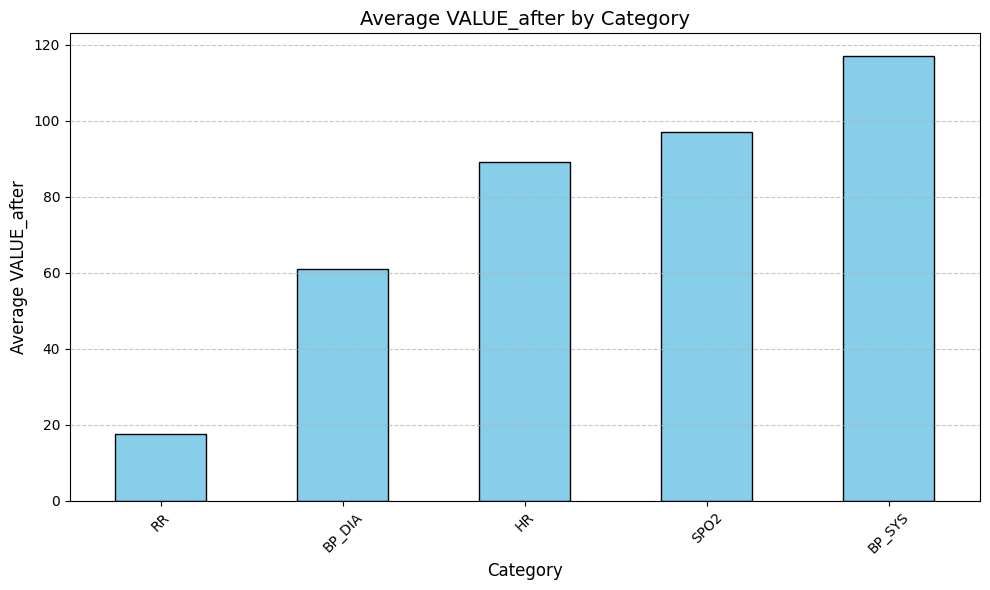

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Group by Category and calculate the mean (or any other aggregate like sum, median, etc.)
category_means = merged_results.groupby('Category')['VALUE_after'].mean()

# Sort values for better visualization (optional)
category_means = category_means.sort_values()

# Plot a bar chart
plt.figure(figsize=(10, 6))
category_means.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Average VALUE_after by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average VALUE_after', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


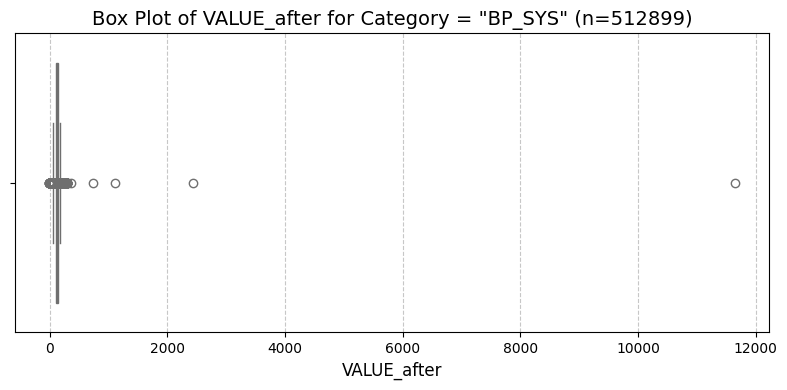

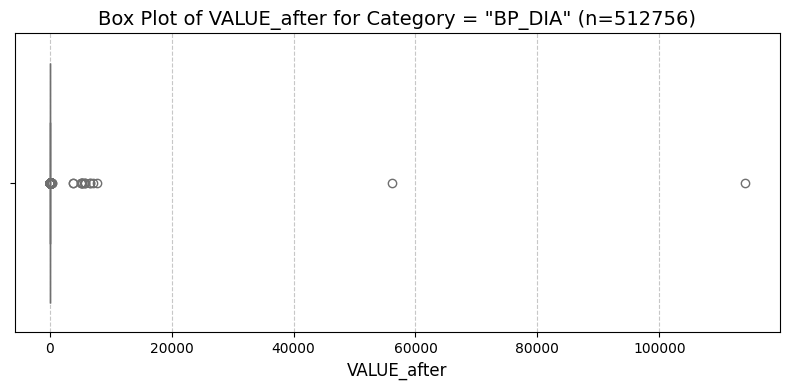

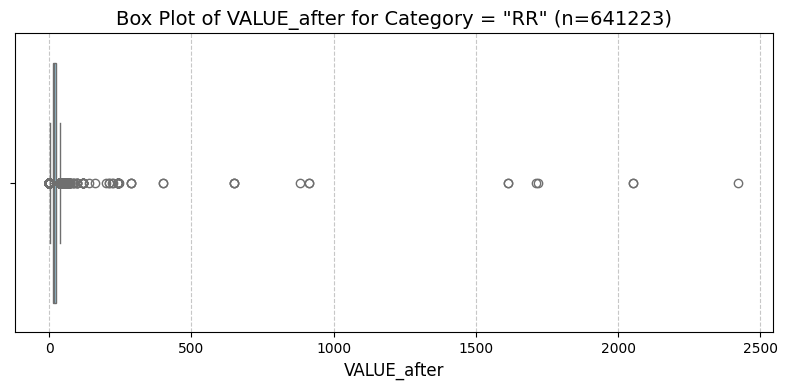

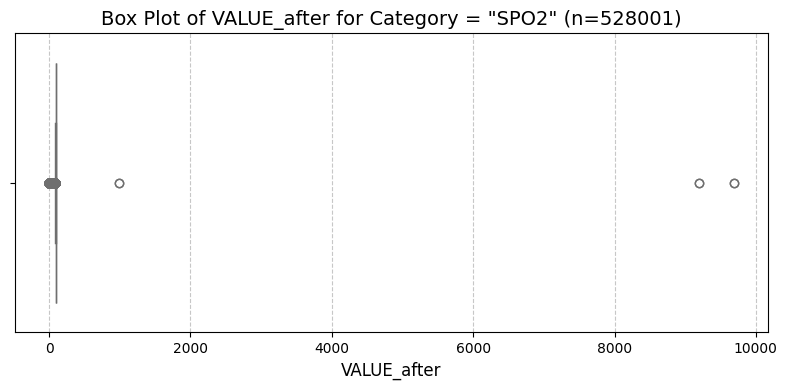

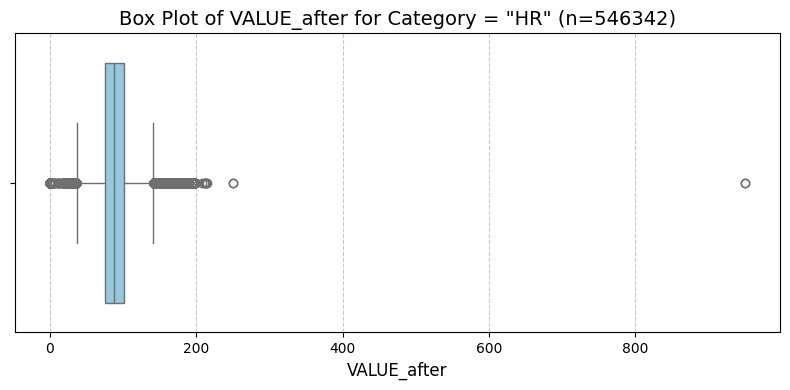

In [40]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



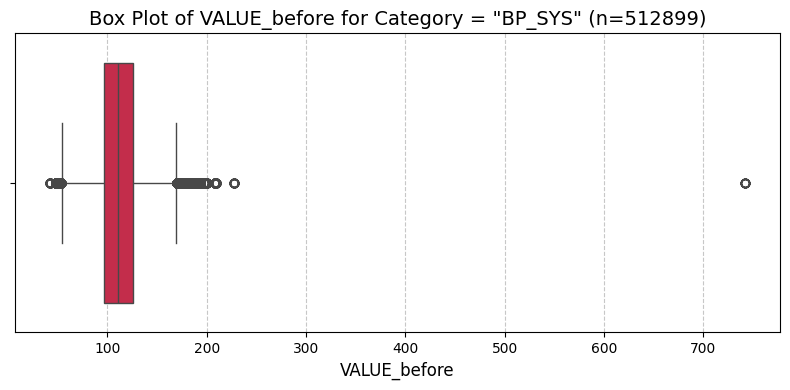

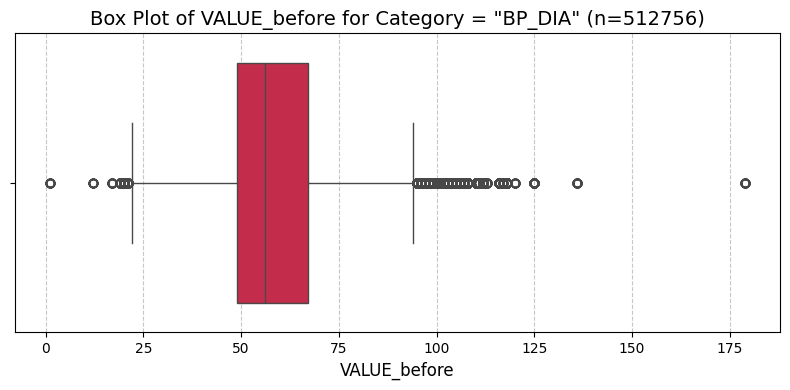

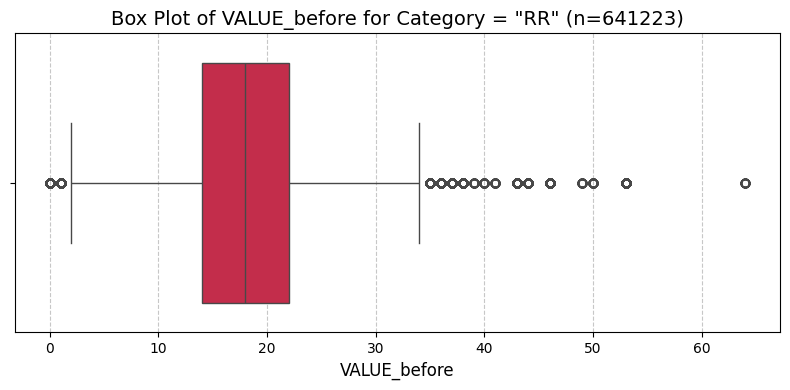

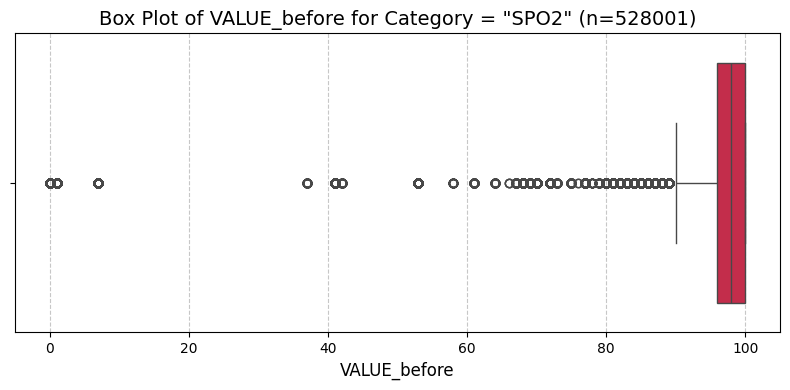

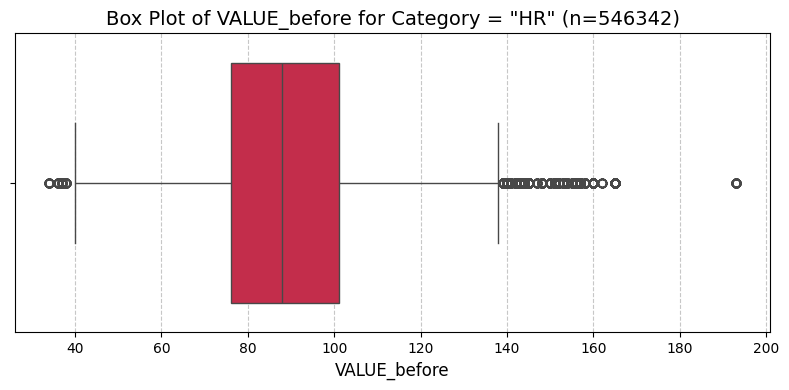

In [41]:
# Plot each vital Category before transfusion 

# Ensure VALUE_before is numeric
merged_results['VALUE_before'] = pd.to_numeric(merged_results['VALUE_before'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_before',
        orient='h',  # Horizontal orientation
        color='crimson'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_before for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_before', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [61]:
# Want to remove VALUE_after and VALUE_before when 
## BP_SYS >= 300
## BP_DIA >= 200
## HR >= 300

# Remove rows based on the specified conditions
filtered_results = merged_results[
    ~(
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_after'] >= 300)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_after'] < 40)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_after'] >= 200)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_after'] < 20)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_after'] >= 300)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_after'] < 15)) | 
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_after'] >= 100)) |
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_after'] < 3)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_after'] >= 100)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_after'] < 40)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_before'] >= 300)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_before'] < 40)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_before'] >= 200)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_before'] < 20)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_before'] >= 300)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_before'] < 15)) | 
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_before'] >= 100)) |
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_before'] < 3)) |
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_before'] >= 100)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_before'] < 40))
    )
]

# Display the filtered DataFrame
filtered_results


,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before
6,87053,2150-07-31 15:10:00,2150-07-31 11:05:00,220179,Non Invasive Blood Pressure systolic,49.0,49.0,mmHg,BP_SYS,2150-07-31 15:05:00,2150-07-31 20:45:00,220050,Arterial Blood Pressure systolic,60.0,60.0,mmHg
7,73755,2138-12-14 05:35:00,2138-12-13 23:13:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2138-12-14 02:39:00,2138-12-14 04:12:00,220179,Non Invasive Blood Pressure systolic,95.0,95.0,mmHg
8,10425,2199-08-17 07:17:00,2199-08-16 20:08:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg
9,10425,2199-08-17 07:17:00,2199-08-16 20:33:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg
10,12712,2196-12-03 13:18:00,2196-12-03 03:15:00,220179,Non Invasive Blood Pressure systolic,51.0,51.0,mmHg,BP_SYS,2196-12-03 15:00:00,2196-12-03 17:15:00,220179,Non Invasive Blood Pressure systolic,77.0,77.0,mmHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,28162,2189-03-13 16:00:00,2189-03-13 12:59:00,211,Heart Rate,77.0,77.0,BPM,HR,2189-03-13 08:45:00,2189-03-13 10:29:00,211,Heart Rate,71.0,71.0,BPM
2741217,32725,2193-09-16 15:00:00,2193-09-16 10:05:00,211,Heart Rate,93.0,93.0,BPM,HR,2193-09-21 17:00:00,2193-09-21 17:26:00,220045,Heart Rate,109.0,109.0,bpm
2741218,8498,2144-08-27 06:00:00,2144-08-27 03:58:00,211,Heart Rate,97.0,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62.0,62.0,bpm
2741219,8498,2144-08-27 08:45:00,2144-08-27 02:06:00,211,Heart Rate,97.0,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62.0,62.0,bpm


In [87]:
# Count the occurrences of each category
print(filtered_results['Category'].value_counts())

# Group by 'SUBJECT_ID' and 'Category', then count the number of entries
group_sub = filtered_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')

# Count the number of unique categories per SUBJECT_ID
unique_category_count = group_sub.groupby('SUBJECT_ID')['Category'].nunique()

# Filter to find SUBJECT_IDs with exactly 5 unique categories
subjects_with_five_categories = unique_category_count[unique_category_count == 5]

# Print the SUBJECT_IDs with exactly 5 unique categories
print(f"Patients with all vitals = {len(subjects_with_five_categories)}")

# Total number of unique patients
total_patients = len(filtered_results['SUBJECT_ID'].unique())
print(f"Total patient counts = {total_patients}")

Category
HR        545448
RR        542221
BP_DIA    511813
BP_SYS    511211
SPO2      270632
Name: count, dtype: int64
Patients with all vitals = 3773
Total patient counts = 5825


Note Missing values issue! 5825 -> 3773

/tmp/ipykernel_1445/3581308070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')


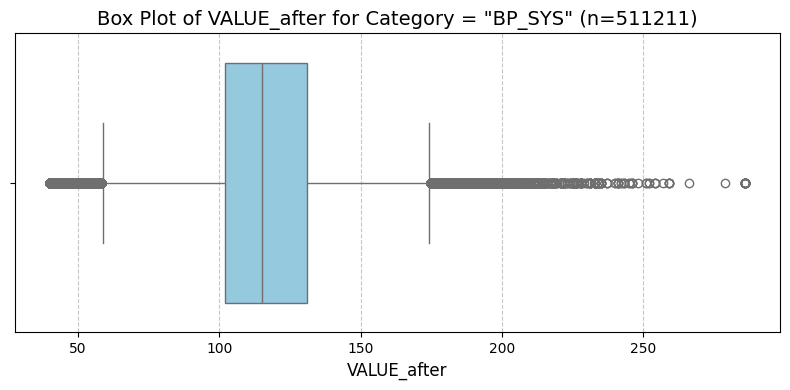

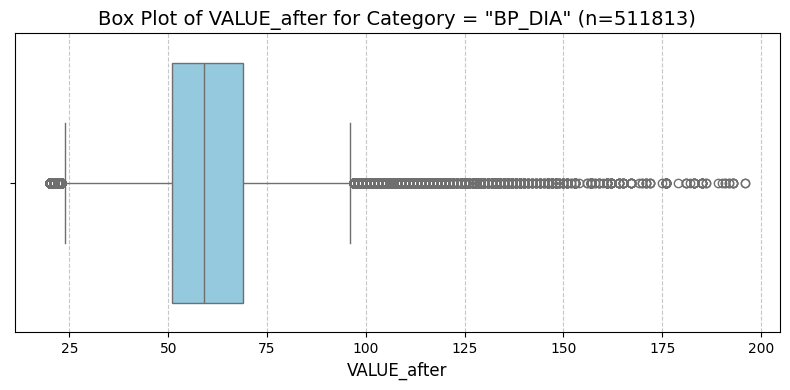

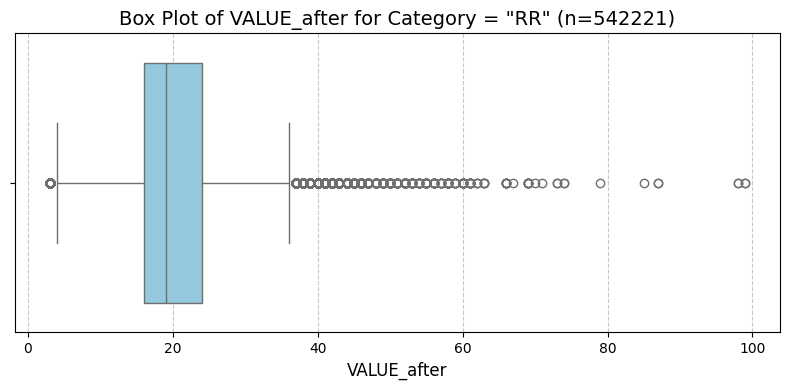

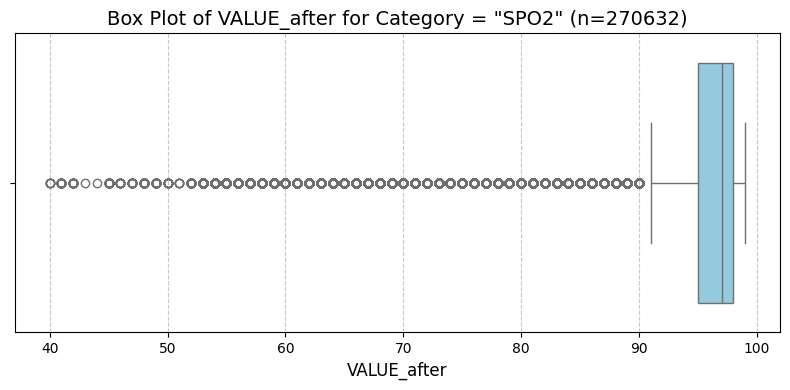

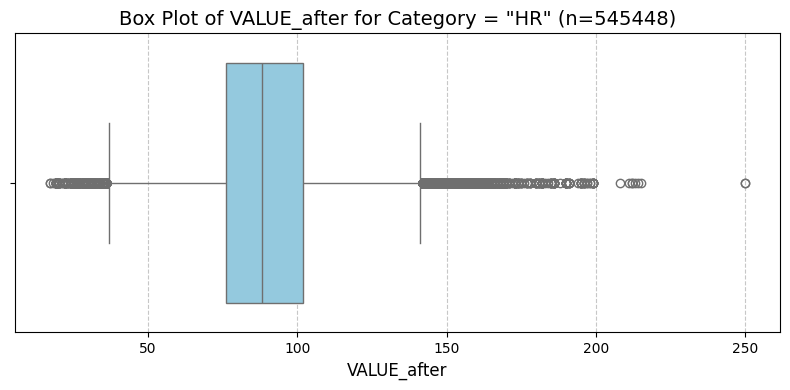

In [62]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = filtered_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = filtered_results[filtered_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/tmp/ipykernel_1445/3524706404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['VALUE_before'] = pd.to_numeric(filtered_results['VALUE_before'], errors='coerce')


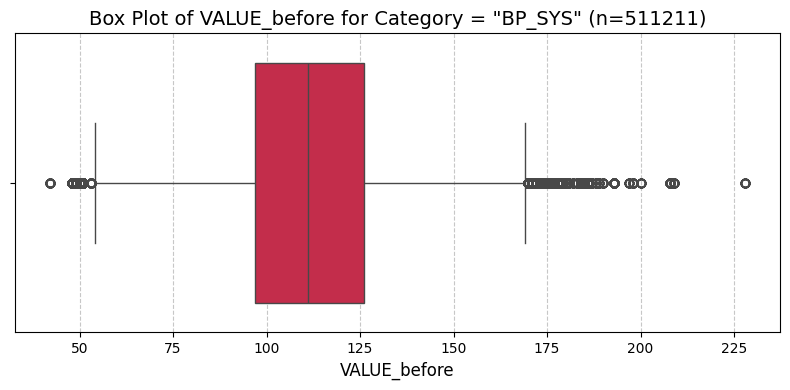

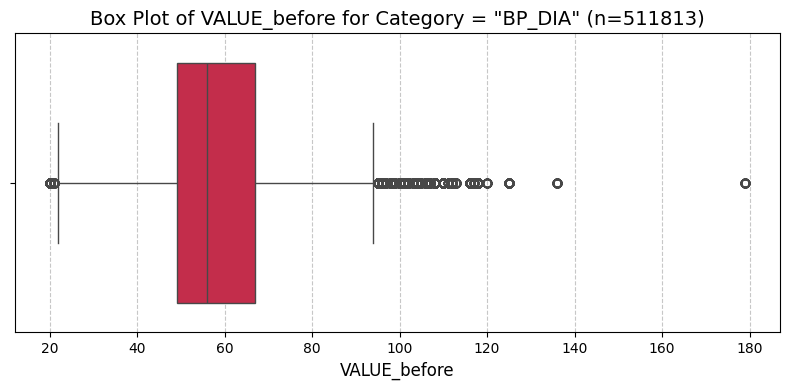

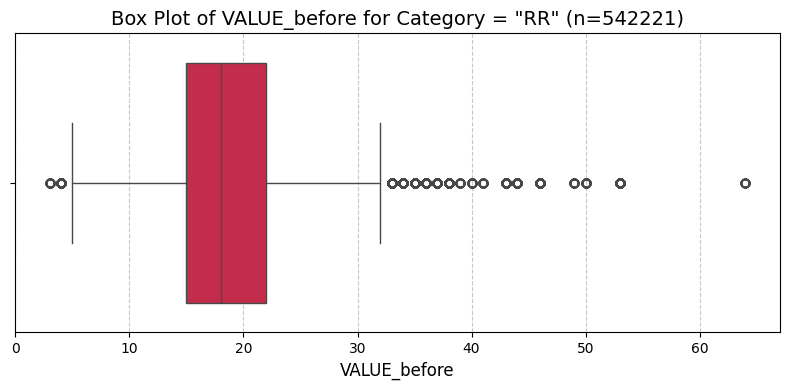

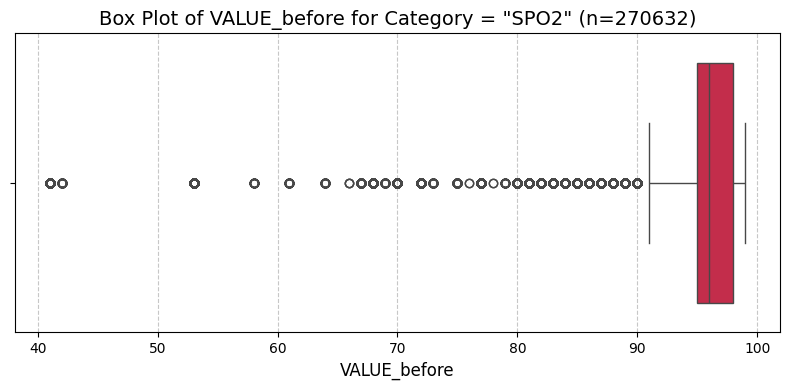

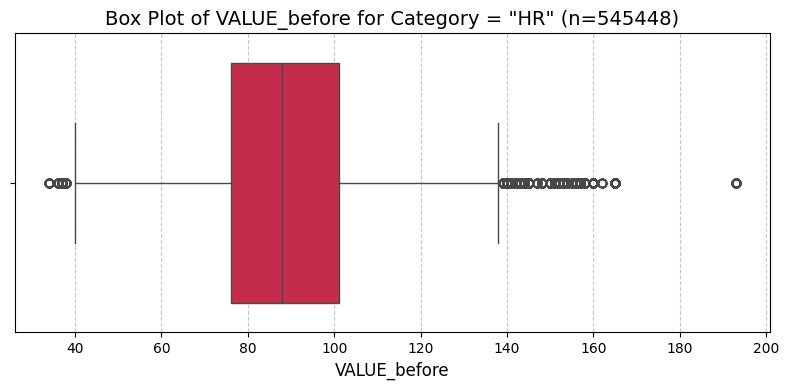

In [63]:
# Plot each vital Category before transfusion 

# Ensure VALUE_before is numeric
filtered_results['VALUE_before'] = pd.to_numeric(filtered_results['VALUE_before'], errors='coerce')

# Get the unique categories
categories = filtered_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = filtered_results[filtered_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_before',
        orient='h',  # Horizontal orientation
        color='crimson'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_before for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_before', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



### Calculate the value differences 

In [68]:
# drop VALUE_bofore = NaN
add_filtered_results = filtered_results[filtered_results['VALUEUOM_before'].notna()]

# Change bpm to Capital BPM
add_filtered_results['VALUEUOM_before'] = add_filtered_results['VALUEUOM_before'].str.replace('bpm', 'BPM', case=False)
add_filtered_results['VALUEUOM_after'] = add_filtered_results['VALUEUOM_after'].str.replace('bpm', 'BPM', case=False)

# Check same units 
add_filtered_results[add_filtered_results['VALUEUOM_after'] != add_filtered_results['VALUEUOM_before']] # should return empty columns


/tmp/ipykernel_1445/1476055081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_filtered_results['VALUEUOM_before'] = add_filtered_results['VALUEUOM_before'].str.replace('bpm', 'BPM', case=False)
/tmp/ipykernel_1445/1476055081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_filtered_results['VALUEUOM_after'] = add_filtered_results['VALUEUOM_after'].str.replace('bpm', 'BPM', case=False)


,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before
27388,32725,2193-09-16 18:00:00,2193-09-16 09:00:00,614,Resp Rate (Spont),NaN,NaN,None,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
27389,32725,2193-09-16 10:38:00,2193-09-16 09:00:00,615,Resp Rate (Total),18.0,18.0,BPM,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
103243,28095,2139-08-06 07:00:00,2139-08-05 23:35:00,220210,Respiratory Rate,26.0,26.0,insp/min,RR,2139-08-05 10:30:00,2139-08-05 20:35:00,618,Respiratory Rate,15.0,15.0,BPM
105551,32725,2193-09-16 18:00:00,2193-09-16 10:05:00,615,Resp Rate (Total),NaN,NaN,None,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
105554,32725,2193-09-16 10:38:00,2193-09-16 10:05:00,619,Respiratory Rate Set,12.0,12.0,BPM,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532842,32725,2193-09-16 17:00:00,2193-09-16 09:00:00,618,Respiratory Rate,25.0,25.0,BPM,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
2611327,32725,2193-09-16 20:45:00,2193-09-16 09:00:00,618,Respiratory Rate,25.0,25.0,BPM,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min
2686900,28095,2139-08-06 11:00:00,2139-08-05 23:35:00,220210,Respiratory Rate,25.0,25.0,insp/min,RR,2139-08-05 10:30:00,2139-08-05 20:35:00,618,Respiratory Rate,15.0,15.0,BPM
2689856,32725,2193-09-16 14:42:00,2193-09-16 09:00:00,615,Resp Rate (Total),21.0,21.0,BPM,RR,2193-09-21 15:01:00,2193-09-21 17:26:00,220210,Respiratory Rate,11.0,11.0,insp/min


In [69]:
# Ensure both columns are numeric
add_filtered_results['VALUE_after'] = pd.to_numeric(add_filtered_results['VALUE_after'], errors='coerce')
add_filtered_results['VALUE_before'] = pd.to_numeric(add_filtered_results['VALUE_before'], errors='coerce')

# Calculate the difference and add it as a new column
add_filtered_results['vital_change'] = add_filtered_results['VALUE_after'] - add_filtered_results['VALUE_before']
add_filtered_results['vital_percentage'] = (add_filtered_results['VALUE_after'] - add_filtered_results['VALUE_before'])/(add_filtered_results['VALUE_before'])

# Display the updated DataFrame
add_filtered_results



/tmp/ipykernel_1445/516548595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_filtered_results['VALUE_after'] = pd.to_numeric(add_filtered_results['VALUE_after'], errors='coerce')
/tmp/ipykernel_1445/516548595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_filtered_results['VALUE_before'] = pd.to_numeric(add_filtered_results['VALUE_before'], errors='coerce')
/tmp/ipykernel_1445/516548595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,vital_change,vital_percentage
6,87053,2150-07-31 15:10:00,2150-07-31 11:05:00,220179,Non Invasive Blood Pressure systolic,49.0,49.0,mmHg,BP_SYS,2150-07-31 15:05:00,2150-07-31 20:45:00,220050,Arterial Blood Pressure systolic,60.0,60.0,mmHg,-11.0,-0.183333
7,73755,2138-12-14 05:35:00,2138-12-13 23:13:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2138-12-14 02:39:00,2138-12-14 04:12:00,220179,Non Invasive Blood Pressure systolic,95.0,95.0,mmHg,-45.0,-0.473684
8,10425,2199-08-17 07:17:00,2199-08-16 20:08:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg,-94.0,-0.652778
9,10425,2199-08-17 07:17:00,2199-08-16 20:33:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg,-94.0,-0.652778
10,12712,2196-12-03 13:18:00,2196-12-03 03:15:00,220179,Non Invasive Blood Pressure systolic,51.0,51.0,mmHg,BP_SYS,2196-12-03 15:00:00,2196-12-03 17:15:00,220179,Non Invasive Blood Pressure systolic,77.0,77.0,mmHg,-26.0,-0.337662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,28162,2189-03-13 16:00:00,2189-03-13 12:59:00,211,Heart Rate,77.0,77.0,BPM,HR,2189-03-13 08:45:00,2189-03-13 10:29:00,211,Heart Rate,71.0,71.0,BPM,6.0,0.084507
2741217,32725,2193-09-16 15:00:00,2193-09-16 10:05:00,211,Heart Rate,93.0,93.0,BPM,HR,2193-09-21 17:00:00,2193-09-21 17:26:00,220045,Heart Rate,109.0,109.0,BPM,-16.0,-0.146789
2741218,8498,2144-08-27 06:00:00,2144-08-27 03:58:00,211,Heart Rate,97.0,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62.0,62.0,BPM,35.0,0.564516
2741219,8498,2144-08-27 08:45:00,2144-08-27 02:06:00,211,Heart Rate,97.0,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62.0,62.0,BPM,35.0,0.564516


/tmp/ipykernel_1445/4020374042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_filtered_results['vital_change'] = pd.to_numeric(add_filtered_results['vital_change'], errors='coerce')


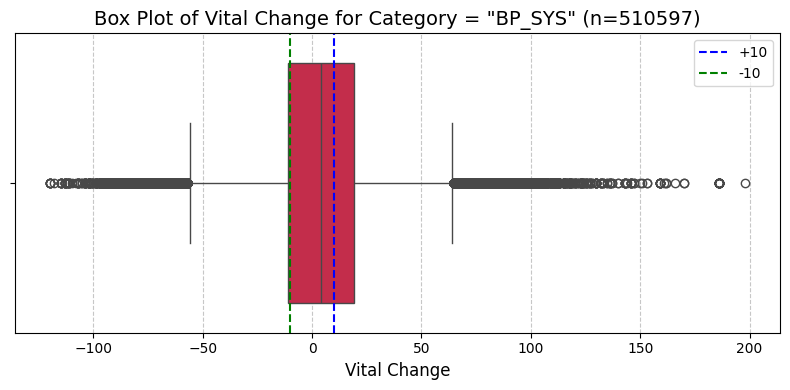

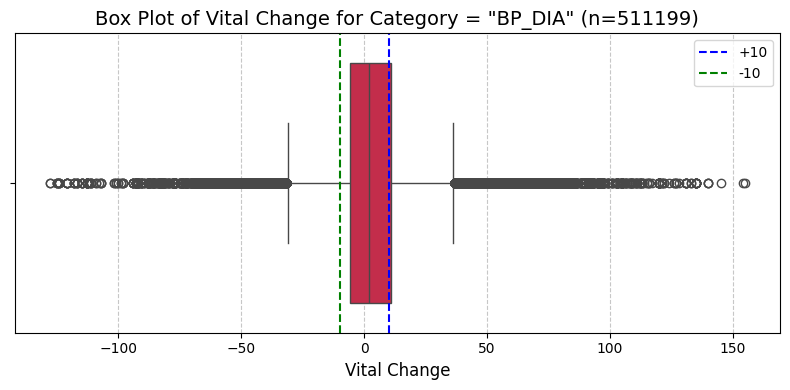

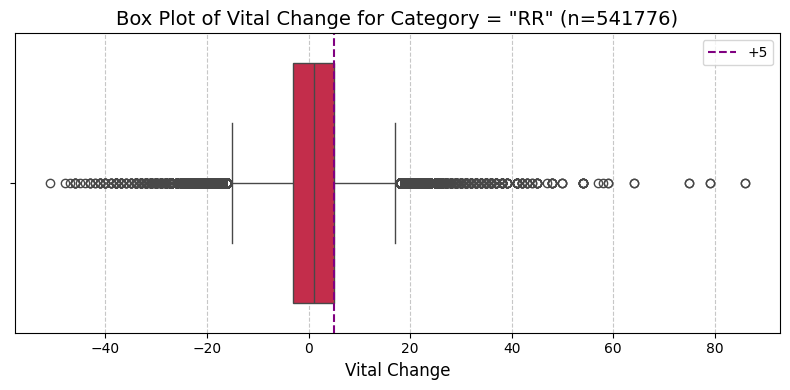

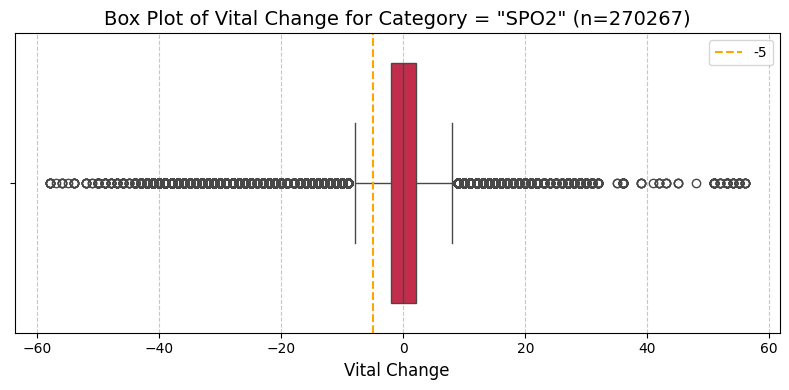

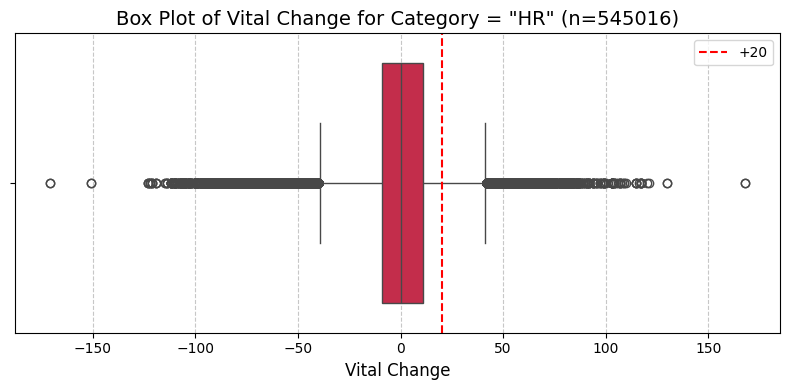

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure "vital_change" is numeric
add_filtered_results['vital_change'] = pd.to_numeric(add_filtered_results['vital_change'], errors='coerce')

# Get unique categories
categories = add_filtered_results['Category'].dropna().unique()

# Create a separate boxplot for each category
for i, category in enumerate(categories, start=1):  # Add index to track plot number
    # Filter the data for the current category
    category_data = add_filtered_results[add_filtered_results['Category'] == category]
    
    # Calculate the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Adjust size for compactness
    
    # Create the box plot
    sns.boxplot(
        data=category_data,
        x='vital_change',
        color='Crimson',  # Optional color
        showfliers=True  # Include outliers
    )
    
    # Add vertical lines based on plot number
    if i in [1, 2]:
        plt.axvline(x=10, color='blue', linestyle='--', label='+10')
        plt.axvline(x=-10, color='green', linestyle='--', label='-10')
    elif i == 3:
        plt.axvline(x=5, color='purple', linestyle='--', label='+5')
    elif i == 4:
        plt.axvline(x=-5, color='orange', linestyle='--', label='-5')
    elif i == 5:
        plt.axvline(x=20, color='red', linestyle='--', label='+20')
    
    # Add a legend for the vertical lines
    plt.legend(loc='best', fontsize=10)
    
    # Customize the plot with count in the title
    plt.title(f'Box Plot of Vital Change for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('Vital Change', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


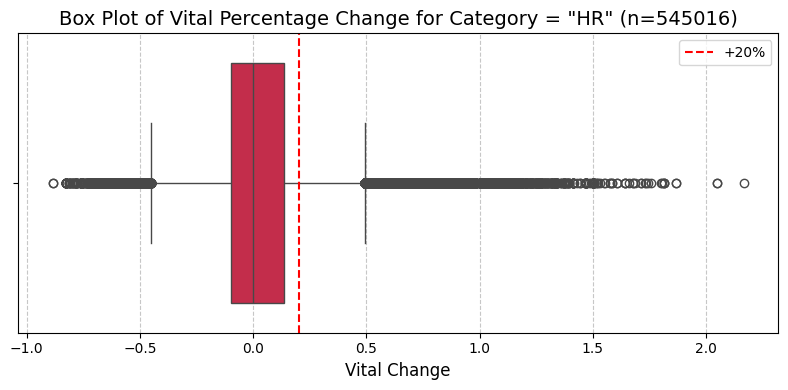

In [71]:
# Also plot HH percentage changes
# Set up the figure
plt.figure(figsize=(8, 4))  # Adjust size for compactness

category_data = add_filtered_results[add_filtered_results['Category'] == "HR"]

# Calculate the count of rows for the current category
category_count = category_data.shape[0]

# Create the box plot
sns.boxplot(
    data=category_data,
    x='vital_percentage',
    color='Crimson',  # Optional color
    showfliers=True  # Include outliers
)

# Add vertical lines based on plot number
plt.axvline(x=0.20, color='red', linestyle='--', label='+20%')

# Add a legend for the vertical lines
plt.legend(loc='best', fontsize=10)

# Customize the plot with count in the title
plt.title(f'Box Plot of Vital Percentage Change for Category = "{category}" (n={category_count})', fontsize=14)
plt.xlabel('Vital Change', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### TACO identification results

In [98]:
# Want to remove VALUE_after and VALUE_before when 
# SpO2 >-5 & <95% SpO2
# RR >+5
# HR >+20%(or 20) 
# BP D/S either OR: >+~10/>+~10 

# Remove rows based on the specified conditions
taco_one_cri = add_filtered_results[
    (
        ((add_filtered_results['Category'] == 'BP_SYS') & (add_filtered_results['vital_change'] >= 10)) |
        ((add_filtered_results['Category'] == 'BP_SYS') & (add_filtered_results['vital_change'] <= -10)) |
        ((add_filtered_results['Category'] == 'BP_DIA') & (add_filtered_results['vital_change'] >= 10)) |
        ((add_filtered_results['Category'] == 'BP_DIA') & (add_filtered_results['vital_change'] <= -10)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_change'] >= 20)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_percentage'] >= 0.20)) | 
        ((add_filtered_results['Category'] == 'RR') & (add_filtered_results['vital_change'] >= 5)) |
        ((add_filtered_results['Category'] == 'SPO2') & (add_filtered_results['VALUE_after'] < 95) & (add_filtered_results['vital_change'] <= -5))
    )
]


# Display the filtered DataFrame
taco_one_cri


,SUBJECT_ID,CHARTTIME_after,endtime,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,vital_change,vital_percentage
6,87053,2150-07-31 15:10:00,2150-07-31 11:05:00,220179,Non Invasive Blood Pressure systolic,49.0,49.0,mmHg,BP_SYS,2150-07-31 15:05:00,2150-07-31 20:45:00,220050,Arterial Blood Pressure systolic,60.0,60.0,mmHg,-11.0,-0.183333
7,73755,2138-12-14 05:35:00,2138-12-13 23:13:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2138-12-14 02:39:00,2138-12-14 04:12:00,220179,Non Invasive Blood Pressure systolic,95.0,95.0,mmHg,-45.0,-0.473684
8,10425,2199-08-17 07:17:00,2199-08-16 20:08:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg,-94.0,-0.652778
9,10425,2199-08-17 07:17:00,2199-08-16 20:33:00,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2201-02-02 21:31:00,2201-02-02 23:01:00,220179,Non Invasive Blood Pressure systolic,144.0,144.0,mmHg,-94.0,-0.652778
10,12712,2196-12-03 13:18:00,2196-12-03 03:15:00,220179,Non Invasive Blood Pressure systolic,51.0,51.0,mmHg,BP_SYS,2196-12-03 15:00:00,2196-12-03 17:15:00,220179,Non Invasive Blood Pressure systolic,77.0,77.0,mmHg,-26.0,-0.337662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741212,40548,2156-08-04 03:35:00,2156-08-03 17:54:00,224689,Respiratory Rate (spontaneous),43.0,43.0,insp/min,RR,2156-08-13 12:29:00,2156-08-13 16:15:00,220210,Respiratory Rate,15.0,15.0,insp/min,28.0,1.866667
2741213,40548,2156-08-02 00:20:00,2156-08-01 19:17:00,224689,Respiratory Rate (spontaneous),43.0,43.0,insp/min,RR,2156-08-13 12:29:00,2156-08-13 16:15:00,220210,Respiratory Rate,15.0,15.0,insp/min,28.0,1.866667
2741214,82609,2129-08-10 09:36:00,2129-08-10 00:59:00,224689,Respiratory Rate (spontaneous),47.0,47.0,insp/min,RR,2129-08-10 22:33:00,2129-08-11 02:20:00,220210,Respiratory Rate,27.0,27.0,insp/min,20.0,0.740741
2741218,8498,2144-08-27 06:00:00,2144-08-27 03:58:00,211,Heart Rate,97.0,97.0,BPM,HR,2144-09-21 13:00:00,2144-09-21 16:00:00,220045,Heart Rate,62.0,62.0,BPM,35.0,0.564516


In [104]:
# BP_DIA OR BP_SYS
taco_one_cri.loc[taco_one_cri['Category'].isin(['BP_SYS', 'BP_DIA']), 'Category'] = "BP"

# Drop duplicates to keep only one BP
taco_results = taco_one_cri.drop_duplicates(subset=['SUBJECT_ID', 'Category'], keep='first')

# Group by 'SUBJECT_ID' and 'Category', then count the number of entries
taco_results = taco_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')

# Count the number of unique categories per SUBJECT_ID
taco_results = taco_results.groupby('SUBJECT_ID')['Category'].nunique()

# Filter to find SUBJECT_IDs with exactly 5 unique categories
taco_results = unique_category_count[unique_category_count == 4]

# Print the SUBJECT_IDs with exactly 5 unique categories
print(f"Patients with all vitals = {len(taco_results)}")

# Total number of unique patients
one_cri_pt = len(taco_one_cri['SUBJECT_ID'].unique())
print(f"Patients who meet one of the 4 vital changing criteria = {one_cri_pt}")


Patients with all vitals = 1889
Patients who meet one of the 4 vital changing criteria = 5774


In [ ]:
## Print TACO example patients

In [ ]:
# Print TACO vital distributions